In [12]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.stats as stats
import scipy.special
#graphing
import matplotlib.pyplot as plt
#stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from statsmodels.distributions.empirical_distribution import ECDF

#import testing
import sys
sys.path.append("../")
import vuong_tests

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
num_bidders2 = 4
num_bidders = 3
mu = 20
sigma = 10

def gen_data(values=stats.logistic(loc=mu, scale=sigma)):
    nobs = 1000
    
    #parameters
    min_bids =num_bidders
    max_bids =num_bidders
    
    bid_types = range(min_bids,max_bids+1)
    prob_type = [1/len(bid_types)]*len(bid_types)
    bidders = np.random.choice(bid_types, nobs, p=prob_type)
    bidders = np.sort(bidders)
    bids = []
    for i in bid_types:
        #count number of obs
        num_i = sum(i == bidders)
        bids_i = values.rvs(size=(num_i,i))
        bids_i =  np.sort(bids_i, axis=1)
        bids_i =  bids_i[:,-2]
        bids = np.concatenate((bids, bids_i))
    
    #draw bids
    return bids,bidders,nobs

values_distr =stats.norm(loc=mu, scale=sigma)
bids,i,nobs = gen_data(values_distr)
print(bids.shape)
print(bids[i == num_bidders].mean())

(1000,)
20.257153239296436


In [14]:
class Auction(GenericLikelihoodModel):
    
    def __init__(self, *args, values_distr=stats.norm, **kwargs):
        super(Auction,self).__init__(*args,**kwargs)
        self.values_distr = values_distr
        
    
    def loglikeobs(self, params):
        bids = self.endog
        i = self.exog[:,0]
        cdf = self.values_distr.cdf(bids,loc=params[0],scale=max(params[1],1e-5))
        pdf = self.values_distr.pdf(bids,loc=params[0],scale=max(params[1],1e-5))
        factorial = scipy.special.factorial(i)/scipy.special.factorial(i-2)  
        
        order_cdf = factorial*pdf*cdf**(i-2)*(1-cdf) #np.log(i) + np.log(cdf) + (i-1)*np.log((1-cdf)) #second highest order statistic
        return np.log(order_cdf)

np.random.seed()
yn,xn,nobs = gen_data(stats.norm(loc=mu, scale=sigma))
model = Auction(yn,xn)
model_fit = model.fit(start_params=[mu,sigma],disp=False)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               Auction Results                                
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                -3343.4
Model:                        Auction   AIC:                             6689.
Method:            Maximum Likelihood   BIC:                             6694.
Date:                Tue, 08 Dec 2020                                         
Time:                        18:48:48                                         
No. Observations:                1000                                         
Df Residuals:                     999                                         
Df Model:                           0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.1206      0.217     92.831      0.000      19.696      20.545
par0          10.2324      0.231     44.364      0.000       9.780      10.684
==============================================================================
"""

In [15]:
def compute_llr(yn,xn):
    
    #fit normal values
    model1 = Auction(yn,xn)
    model1_fit = model1.fit(start_params=[mu,sigma],disp=False)
    ll1 = model1.loglikeobs(model1_fit.params)
    
    #fit logistic values
    model2 = Auction(yn,xn*num_bidders2/num_bidders)
    model2_fit = model2.fit(start_params=[mu,sigma],disp=False)
    ll2 = model2.loglikeobs(model2_fit.params)
    
    llr = ll1.sum() - ll2.sum()
    omega2 = (ll1- ll2).var()
    return llr,np.sqrt(omega2)

yn,xn,nobs = gen_data()
print(compute_llr(yn,xn))

(2.3236379712798225, 0.029975324788670935)


0
0


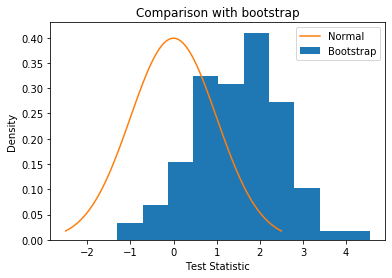

In [16]:
yn,xn,nobs = gen_data()
print(vuong_tests.bootstrap_test(yn,xn,nobs,compute_llr,hist=True))
print(vuong_tests.regular_test(yn,xn,nobs,compute_llr,hist=True))

plt.title("Comparison with bootstrap")
plt.xlabel("Test Statistic")
plt.ylabel("Density")
plt.legend()
plt.savefig('../figs/bootstrap_compare_bidders')
plt.show()

In [17]:
reg,boot,llr, omega = vuong_tests.monte_carlo(100,gen_data,compute_llr)
print("reg: %s, boot: %s, llr:%s, omega:%s"%(reg,boot,llr, omega))

reg: [0.94 0.06 0.  ], boot: [0.91 0.08 0.01], llr:0.5690036148998024, omega:0.034390985434368665


In [18]:
def setup_shi(yn,xn):
    model1 = Auction(yn,xn)
    model1_fit = model1.fit(start_params=[mu,sigma],disp=False)
    ll1 = model1.loglikeobs(model1_fit.params)
    grad1 =  model1.score_obs(model1_fit.params)    
    hess1 = model1.hessian(model1_fit.params)
    
    #fit logistic values
    model2 = Auction(yn,xn*num_bidders2/num_bidders)
    model2_fit = model2.fit(start_params=[mu,sigma],disp=False)
    ll2 = model2.loglikeobs(model2_fit.params)
    grad2 =  model2.score_obs(model2_fit.params)    
    hess2 = model2.hessian(model2_fit.params)
    
    return ll1,grad1,hess1,ll2,2, grad2,hess2,2

yn,xn,nobs = gen_data()
ll1,grad1,hess1,ll2,k1, grad2,hess2,k2 = setup_shi(yn,xn)

In [19]:
shi_result = vuong_tests.monte_carlo_shi(100,setup_shi,gen_data)
print(shi_result)

[1. 0. 0.]


In [ ]:
#normal distribution, 5, 20 bidders
#reg: [0.82 0.18 0.  ], boot: [0.78 0.22 0.  ], llr:2.602891682004338, omega:0.07058141556876986
#shi: [0.97 0.03 0.  ]

#logistic distribution, num_bidders2 = 3, num_bidders = 6, mu = 20, sigma = 5
#reg: [0.85 0.15 0.  ], boot: [0.8 0.2 0. ], llr:2.0640882842566497, omega:0.07172781203070461

#logistic distribution, num_bidders2 = 6, num_bidders = 2, mu = 20, sigma = 5
#reg: [0.85 0.15 0.  ], boot: [0.9 0.1 0. ], llr:1.699842999683483, omega:0.07413523308440399'
#[0.78 0.22 0. ], boot: [0.78 0.22 0. ]
#[0.99 0.01 0.  ]

#num_bidders2 = 3, num_bidders = 4, mu = 20, sigma = 10
#reg: [0.6 0.4 0. ], boot: [0.7 0.3 0. ], llr:1.5855838892164684, omega:0.03291415905392439
#reg: [0.56 0.44 0.  ], boot: [0.5 0.5 0. ], llr:1.9897437189929996, omega:0.03341120424668039

#num_bidders2 = 4, num_bidders = 3, mu = 20, sigma = 10